# Implemention of the Behavior Pattern Method
nach 
Diamantini, C., Genga, L. & Potena, D. Behavioral process mining for unstructured processes. J Intell Inf Syst 47, 5–32 (2016). https://doi.org/10.1007/s10844-016-0394-7

In [1]:
import pm4py
from pm4py.objects.log.obj import EventLog
from pm4py.objects.log.obj import Event
from pm4py.objects.log.obj import Trace
from pm4py.objects.petri_net.obj import PetriNet
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.objects.petri_net.exporter import exporter as pnml_exporter
from pm4py.objects.petri_net.importer import importer as pnml_importer

import os
import json
from src.helper import HiddenPrints 
from tqdm import tqdm

## Import XES File

Only XES Import Works! Probably, because we using attributes implemented by XES like:
ActivityName:"concept:name"
RessourceName:"org:resource"
LifecycleTransition. "lifecycle:transition"

from https://pm4py.fit.fraunhofer.de/documentation#item-impoort-xes

Event Log, und Trace: 
https://pm4py.fit.fraunhofer.de/static/assets/api/2.2.16/pm4py.objects.log.html?  highlight=objects%20log%20obj%20eventlog#pm4py.objects.log.obj.EventLog

EventLog[] => Trace  
EventLog[][] => Event of Trace

#### Ist eine Bereiningung des Event Logs nötigt auf => Aktivitäten 
Der event Log zeigt die Events nicht die ausgeführten Aktivitäten, wirkt sich das aus auf die Generierung des Petri Net und Alignemt, weil die Events verwendet werden nicht die Aktivitäten.

In [2]:
path = "datasets/02_TestCompletedFFF_onlyTaskItems_simpleFilter.xes"
#path = 'datasets/Hospital_log.xes'
log = xes_importer.apply(path)
log = pm4py.filter_case_size(log, 0, 480)
# log = pm4py.filter_case_size(log, 0, 300)

parsing log, completed traces :: 100%|██████████| 81/81 [00:01<00:00, 72.30it/s]


In [3]:
# Event dict Eigenschaften 
print(log[0][4])

{'lifecycle:transition': 'manualskip', 'time:timestamp': datetime.datetime(2019, 11, 20, 13, 59, 39, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'cdb_process_id': 'P00062587', 'concept:instance': 326312, 'concept:name': 'Reset to New', 'description': '[Task discarded]', 'division': 'UNDEFINED', 'msgtype': 'CANCEL', 'org:resource': '1079b397-2699-11ec-8124-0050568b0d8f', 'task_id': 'T00010909'}


BoxPLot, um Size Verteilung zu sehen und Ausreißer zu identifizieren.
Ziel dadurch das Modell zu vereinfachen und Zeit in der Berechnung der Alignment zu sparen: 

Der BoxPLot zeigt anhand der Trace Sizes 2 Ausreißer an: >800 und >300


124.525


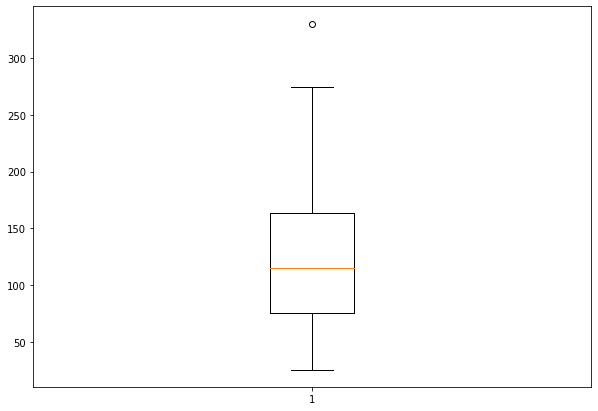

In [4]:
import matplotlib.pyplot as plt

# Creating dataset
data = list()
summe= 0
for trace in log:
    trace_len = len(trace)
    data.append(trace_len)
    summe += trace_len

print(summe/len(data))

fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(data)
 
# show plot
plt.show()

## Get Real Welt Modell as Petri Net 
with Inductive Miner Infrequent for Casual Relation  
from https://pm4py.fit.fraunhofer.de/documentation#item-3-2  
Parameters: https://pm4py.fit.fraunhofer.de/static/assets/api/2.1.0/pm4py.algo.discovery.inductive.html?highlight=parameters%20activity_key#pm4py.algo.discovery.inductive.parameters.Parameters

The noise threshold (between 0.0 and 1.0) to be used. Default: 0.2

Dauer ca. 2min

In [5]:
from src.log_classifier_helper import addDivisionClassifier
from src.log_classifier_helper import addRessourceClassifier


### Adding Orga Unit (und lifecycleTransition (?)) 
Ich verwende Division, weil Ressource ein zu komplexes Modell liefern würde und die Ressourcen verschlüsselt. Daher schwierig Aussagekraft abzuleiten. Aussage kräftiger, wenn Divisionen angeschaut. 

Probleme mit dem Discovery Modell mit dem zusammengesetzten Classifier aus der Division und Name bzw. Ressource und Name.

Nach meinen Verständnis berücksichtigt das Discovery Verfahren den Lifecycle, daher wird.

In [6]:
##### Import Section

petri_net_division_name_Path = os.path.join("output/petri_net_division_name.pnml")
petri_net_name_Path = os.path.join("output/petri_net_name.pnml")
petri_net_hospital_Path = os.path.join("output/hospital_petrinet.pml")
# Change on Classifier Change
path = petri_net_name_Path

net, initial_marking, final_marking = pnml_importer.apply(path)



In [7]:
numberDict = dict()
for trans in net.transitions:
    index = 0
    if(trans.label == None):
        continue
    for trans2 in net.transitions:
        if(trans.label == trans2.label):
            index += 1
            numberDict[trans.label] = index
            
for key, number in numberDict.items():
    if(number >1):
        print(key, number)
            
            
    

In [8]:
std_classifier = "concept:name"
customClassifierDivision = "customClassifierDivision"
customClassifierRessource = "customClassifierRessource"
# Change on Classifier Change
classifier=std_classifier
if(classifier == customClassifierDivision):
    addDivisionClassifier(log, classifier)
if(classifier == customClassifierRessource):
    addRessourceClassifier(log, classifier)

ccStdAlignmentPath = 'output/custom_cost_alignment_name_classifier/'
ccDivisionAlignmentPath = 'output/custom_cost_alignment_division/'
ccRessource = 'Not existing'
# Change on Classifier Change
alignmentPathFolder = ccStdAlignmentPath


## Auswertung der Kanten 
Aus dem Event Log wurde mithilfe des Inductive Miner Infrequnent (vgl. Leemans at al 2014) ein Real welt Modell erstellt. less frequent behavior, loops ect. finden (vgl. Dimanatini)  
Output Petrie Netz. Ergebnis dient zur Grundlage für für die Casual Relation Eigenschaft und im folgende für das Instance Ordering, d.h. beeinflusst die Qualitäten der Kanten Bindungen der Instance Graphen.


Zwei Ansätze ausprobiert:  
Event Name Only - würde in nachträgliches einfügen der Ressource oder Division benötigen.
Custom Classifier Division - mit Division nach Methode, ergibt aber deutlich komplexere Modelle
Custom Classifiier Ressource - Algorithmus hat nicht abgeschlossen, unbekannte Ursache

In [9]:
print('Transitionen: ', len(net.transitions))
print('Silent Transitionen: ', len({trans for trans in net.transitions if trans.label == None}))
print('Not Silent Transitionen: ', len({trans for trans in net.transitions if trans.label != None}))

Transitionen:  332
Silent Transitionen:  226
Not Silent Transitionen:  106


Wie hoch ist der Anteil an silent Transition; Transitionen, die hinzugefügt wurden, um das Verhalten zu simulieren. Stille Aktivitäten
Häufigkeit Silent Transitionen, Silent Trans und Aktivitäten und zwischen Aktivitäten:

Mit Division Classifier:  
Transitionen:  560  
Silent Transitionen:  406  
Silent Transitionen:  154  

Ohne Custom Classifier:  
Transitionen:  332  
Silent Transitionen:  226  
Silent Transitionen:  106  

Kritik an Statistik: 
einige Silent Transitionen stehen für tauJoin und Tausplit => Verhaltensrelevant, herausnehmen? weiß zu wenig




In [10]:
anteilSilent = round(406 / 560 *100, 2)
anteilActivities = round(154 / 560  *100, 2)

print(anteilSilent, anteilActivities)

anteilSilent = round(226 / 332 *100, 2)
anteilActivities = round(106 / 332  *100, 2)

print(anteilSilent, anteilActivities)

72.5 27.5
68.07 31.93


Wir stellen fest, dass der Anteil der Silent Transitionen überwiegt im Vergleich zu den mit Aktivitäten.


## From Petri Netz zu Instance Ordering  

### Casual Relation:

Zwei events i, j haben eine Causal Relation, wenn i erst abgeschlossen werden muss, damit j ausgeführt werden kann.  
Das Petri Netz ist Modell und die CR Relation, bzw. die Grundlage davon. 

Es sind in der relation keine Silent Transitionen aus dem 
Petri Netz enthalten!

### Instance Ordering: 

i, j und k sind Events; i<k<j  
Es besteht eine CR Relation zwischen i und j;  
und  
(Es darf keine CR Relation zwischen i und k:  
Oder  
Es darf keine CR Relation zwischen k und j geben;)  

Bezug zum Petri Netz, welches als Grundlage für die CR Relation verwendet wird:  
Ein Event ist im Petri Netz eine Transition; der Aktivitäten Name kann über Label aufgerufen werden.
Im Ordering sid keine silent Transitionen aus dem Petri Net enthalten

Siehe hierzu auch  
https://pm4py.fit.fraunhofer.de/static/assets/api/2.2.16/pm4py.objects.petri_net.html?highlight=petrinet#pm4py.objects.petri_net.obj.PetriNet  
https://pm4py.fit.fraunhofer.de/documentation#item-4-2

In [11]:
from src.casual_releation import calculateCR

In [12]:
cr = calculateCR(net)
print('# Casual Relations', len(cr))

""" 
Depth ist der Wert wie viele Aktivitäten zwischen dem Casual Predecessor und dem Casual Successor
Starts at -1 (Überspringt sich selbst als predecessor)), -1 is an self-loop, 0 fullFills an instanceOrdering characteristic    
"""
instanceOrdering = {(source,target) for (source,target,depth) in cr if(depth < 1)}
print('# Direkte Nachfolger mit der Instance Ordering Eigenschaft', len(instanceOrdering))
print('# Nachfolger Tiefe -1', len({(source,target) for (source,target,depth) in cr if(depth == -1)}))
print('# Nachfolger Tiefe 0', len({(source,target) for (source,target,depth) in cr if(depth == 0)}))
print('# Nachfolger Tiefe 1', len({(source,target) for (source,target,depth) in cr if(depth == 1)}))
print('# Nachfolger Tiefe 2', len({(source,target) for (source,target,depth) in cr if(depth == 2)}))
print('# Nachfolger Tiefe 3', len({(source,target) for (source,target,depth) in cr if(depth == 3)}))
print('Min Tiefe: ', min(cr,key=lambda cr: cr[2])[2]) # -1 => self loop exists
print('Maximum Tiefe: ', max(cr,key=lambda cr: cr[2])[2])

100%|██████████| 332/332 [00:00<00:00, 8222.77it/s]

# Casual Relations 6756
# Direkte Nachfolger mit der Instance Ordering Eigenschaft 2202
# Nachfolger Tiefe -1 86
# Nachfolger Tiefe 0 2116
# Nachfolger Tiefe 1 1260
# Nachfolger Tiefe 2 908
# Nachfolger Tiefe 3 747
Min Tiefe:  -1
Maximum Tiefe:  12


### Problem My Instance ordering Implementation
![](assets\my_implementation_instance_ordering_problem1.png "Title")
![](assets\my_implementation_instance_ordering_problem2.png "Title")
![](assets/my_implementation_instance_ordering_problem1.PNG "Title")
![](assets/my_implementation_instance_ordering_problem2.PNG "Title")

## Instance Graphen

Werden aus dem Instance Ordering, welches  aus der vorangegangen Methode erhalten haben.
Es wird nun nach den Vorgaben aus den Wissenschaftlichen Beitrag ein Instanz Graph erstellt.  
Ein Instance Graph wird ein Tupel aus Knoten, edges und einen Dictionary sein, welches ein Mapping zwischen dem den Knoten und dem entsprechenden Log Event darstellt.

Referenzen zum Event Log
https://pm4py.fit.fraunhofer.de/static/assets/api/2.2.16/pm4py.objects.log.html?highlight=eventlog#pm4py.objects.log.obj.EventLog



In [13]:
## instance_graph.py
from src.instance_graph import genInstanceGraph
from src.instance_graph import buildingInstanceGraphsFromLog
from src.draw_instance_graph import drawInstanceMultipleIGraphs

### Generiere alle Instanz Graphen ohne Reparatur

In [14]:
instanceGraphs = dict()
cr = calculateCR(net)
for index, instance in enumerate(log):
    nodes, edges, nodeEventDict = genInstanceGraph(instance, cr, classifier)
    # For test dataset 1
    # instanceGraphs[instance.attributes['variant']] =(nodes, edges, nodeEventDict)
    # For Hospital dataet
    instanceGraphs['instance'+ str(index)] =(nodes, edges, nodeEventDict)


100%|██████████| 332/332 [00:00<00:00, 7603.52it/s]


In [15]:
from src.draw_instance_graph import createGraphVizGraph
from src.draw_instance_graph import drawInstanceGraphViz
    

In [16]:
""" for key, ig in instanceGraphs.items():
    dot = createGraphVizGraph(ig, key)
    dot.render(directory='output/graphs-viz', view=True) """
drawInstanceGraphViz(instanceGraphs, 'output/graphs-viz')  


100%|██████████| 80/80 [11:34<00:00,  8.68s/it]


In [58]:
## Draw Reparierte INstance Graphen
folderPath_custom_class_division = 'output/unrepaired_graphs_class_division/'
folderPath_name = 'output/unrepaired_graphs_name/'
# change on on Classifier Change
folderpAthDrawings = folderPath_name
#drawInstanceMultipleIGraphs(instanceGraphs, folderpAthDrawings)

## Repair irreguläre Instanz Graphen 

### PM4Py Alignment: Kosten der Abweichen benutzen zum aufspüren irregulärer Traces
https://pm4py.fit.fraunhofer.de/documentation#item-5-2

Spüren mithilfe der aligmentn Kosten auf ob deletet oder inserted. Nach Definiion.

Docs: https://pm4py.fit.fraunhofer.de/static/assets/api/2.2.16/pm4py.algo.conformance.alignments.petri_net.html#pm4py.algo.conformance.alignments.petri_net.algorithm.apply_log

Alignment zu berechnen dauert lange in Jupyter: bis zu 30h

Source: S. 105 & 106 Diamantini, C., Genga, L., Potena, D., and van der Aalst, W. 2016. “Building instance graphs for highly variable processes,” Expert Systems with Applications (59), pp. 101-118 (doi: 10.1016/j.eswa.2016.04.021).


### Alignment
* Sync move: the classification of the event corresponds to the transition label; in this case, both the trace and the model advance in the same way during the replay.
+ Move on log: for couples where the second element is », it corresponds to a replay move in the trace that is not mimicked in the model. This kind of move is unfit and signal a deviation between the trace and the model.
* Move on model: for couples where the first element is », it corresponds to a replay move in the model that is not mimicked in the trace. For moves on model, we can have the following distinction:
  * Moves on model involving hidden transitions: in this case, even if it is not a sync move, the move is fit.
  * Moves on model not involving hidden transitions: in this case, the move is unfit and signals a deviation between the trace and the model.
  
from https://pm4py.fit.fraunhofer.de/documentation#item-5-2  
Stimmt mit der Literatur überein:

### Irregulare Traces / Move in the Model
Irregular Traces are Move in the Models. In such a way it is described in  
S. 106 Diamantini, C., Genga, L., Potena, D., and van der Aalst, W. 2016. “Building instance graphs for highly variable processes,” Expert Systems with Applications (59), pp. 101-118 (doi: 10.1016/j.eswa.2016.04.021).

log move = inserted; model move = deleted vgl. s. 106 in Diamantini et al 2016 

In [59]:
""" # Ansatz  in klein Teile spalten!
# conformance_with_alignment in 
from src.conformance_with_alignment import loadAlignment
from src.conformance_with_alignment import printEvaluationAlignment


alignmentDict = loadAlignment(log, alignmentPathFolder)
for key in alignmentDict:
    printEvaluationAlignment(log, alignmentDict, key)
 """

' # Ansatz  in klein Teile spalten!\n# conformance_with_alignment in \nfrom src.conformance_with_alignment import loadAlignment\nfrom src.conformance_with_alignment import printEvaluationAlignment\n\n\nalignmentDict = loadAlignment(log, alignmentPathFolder)\nfor key in alignmentDict:\n    printEvaluationAlignment(log, alignmentDict, key)\n '

Alignment Berechnung in kleine Teile aufgespalten und in Json gesichert:  
JSON from here https://www.geeksforgeeks.org/read-write-and-parse-json-using-python/?ref=lbp

In [60]:
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments
from src.custom_cost_function import getCostFunctionParameter

In [61]:
outputPath = './output/custom_cost_alignment_hospital.json'
parameters = getCostFunctionParameter(net)
aligned_traces = alignments.apply_log(
    log, net, initial_marking, final_marking, parameters=parameters)

## save as json
os.makedirs(os.path.dirname(outputPath), exist_ok=True)
with open(os.path.join(outputPath), 'w') as f:
    json.dump(aligned_traces, f)

aligning log, completed variants ::   0%|          | 0/918 [00:00<?, ?it/s]

Note that although edges in Ea are not allowed by the model, using these edges to connect the occurred insertion we limit significantly the overgeneralization with respect the original iIG IGins .


## Reparierte Instance Graphen bauen

In [13]:
from src.conformance_with_alignment import loadAlignment
from src.conformance_with_alignment import printEvaluationAlignment

In [24]:
variantAlignmentDict = loadAlignment(log, 'output/custom_cost_alignment_name/')
printEvaluationAlignment(log, variantAlignmentDict, 'Variant 14')
variantAlignmentDict['Variant 14']

Variant 14 Trace | Alignments: 63|172
irregular Traces (ohne Silent): 0
Fitness: 1.0
irregular Traces Anteil From Trace: 0.0
irregular Traces Anteil From Alignemt: 0.0
ModelMoves:0
ModelMovesSil:1
LogMoves:0
LogMovesSil:0
______________________


{'alignment': [['>>', None],
  ['>>', None],
  ['>>', None],
  ['Product Modification Responsible is correctly assigned?',
   'Product Modification Responsible is correctly assigned?'],
  ['>>', None],
  ['Product Modification Responsible is correctly assigned?',
   'Product Modification Responsible is correctly assigned?'],
  ['>>', None],
  ['>>', None],
  ['Check Part Roles, Docs & Parts to be changed',
   'Check Part Roles, Docs & Parts to be changed'],
  ['>>', None],
  ['>>', None],
  ['>>', None],
  ['Reset to New', 'Reset to New'],
  ['>>', None],
  ['Reset to New', 'Reset to New'],
  ['>>', None],
  ['>>', None],
  ['>>', None],
  ['EC Responsible has rejected', 'EC Responsible has rejected'],
  ['>>', None],
  ['>>', None],
  ['>>', None],
  ['Check Part Roles, Docs & Parts to be changed',
   'Check Part Roles, Docs & Parts to be changed'],
  ['>>', None],
  ['>>', None],
  ['>>', None],
  ['>>', None],
  ['Continue to Evaluation', 'Continue to Evaluation'],
  ['>>', None],
 

In [ ]:
# net, initial_marking, final_marking = pnml_importer.apply(os.path.join(importPath))
variantAlignmentDict = loadAlignment(log, alignmentPathFolder)
#with HiddenPrints():
instanceGraphsDict = buildingInstanceGraphsFromLog(log,net,variantAlignmentDict,classifier)


100%|██████████| 332/332 [00:00<00:00, 6720.41it/s]


Variant 1
nodes 53
Anzahl Edges InstanceGraph build: 1304
Variant 2
nodes 54
Anzahl Edges InstanceGraph build: 1244
Variant 3
nodes 57
Anzahl Edges InstanceGraph build: 1281
Not deletedEventHasCR: No deletion Add! P00066997
Not deletedEventHasCR: No deletion Add! P00066997
Not deletedEventHasCR: No deletion Add! P00066997
Not deletedEventHasCR: No deletion Add! P00066997
Not deletedEventHasCR: No deletion Add! P00066997
Not deletedEventHasCR: No deletion Add! P00066997
Variant 4
nodes 48
Anzahl Edges InstanceGraph build: 987
Variant 5
nodes 15
Anzahl Edges InstanceGraph build: 37
Variant 7
nodes 72
Anzahl Edges InstanceGraph build: 1305
Not deletedEventHasCR: No deletion Add! Edit CAD documents
Not deletedEventHasCR: No deletion Add! Edit CAD documents
Not deletedEventHasCR: No deletion Add! Review CAD document
Not deletedEventHasCR: No deletion Add! Review CAD document
Not deletedEventHasCR: No deletion Add! Plausibility check
Not deletedEventHasCR: No deletion Add! Plausibility check

### Auswertung Reparatur 

Einige wiederkehrende Nodes (Deletion Alignments) könnten nicht repeariert werden, weil sie kein Casual Relation hatten. Mögliche Ursache nicht Teil des Petri Netzes <= nicht in Discovery eibezogen, weil zuwenig Occurrance (Eigenschaft des Disc Algo).

<s>Ehemaliges Problem: Deletion ignoriert, die auch als Insertion aufgetaucht sind, wegen elif </s>

Einige Fälle von Deletion, ohne wo keine Casual Predecessor gefunden mit dem Deletion Event asl Successor, aber Successor mit Deletion als Predecessor gefunden.
TODO: Lösung ???

Vereinzelt gibt es Fälle in denen, kein CR Relation in der Kombi deletionEvent ; in Nodes und anders herum.
Vllt. Discovery Algo Output Quali schecht, vgl. Fixed Problem, wegen namen Kürzung

Einige Graphen ohne Reperatur YAY!

Vereinzelt sehr viele Edges im Vergleich zu den Nodes. z.B. Varianten 36, 19, 33,34

<s>Einige Aktivitäten Namen könne aufgrund der Namenskürzung sich gleichen, z.B. mehrere Aktivitäten mit Info im Namen.  
Fixed! </s>


Im Ganzen kein optimales Ergebnis, aber man kann damit arbeiten. Warte Division Korrektur ab! 


In [ ]:
from src.draw_instance_graph import drawInstanceMultipleIGraphs

In [1]:
## Draw Reparierte INstance Graphen
folderPath_custom_class_division = 'output/graphs_class_division/'
folderPath_name = 'output/graphs_name/'
# change on on Classifier Change
folderpAthDrawings = folderPath_name
#drawInstanceMultipleIGraphs(instanceGraphsDict, folderpAthDrawings)


### Eigenschaften die der die Graphen erfüllen müssen, für Forschunsgfrage



## Subgraph Mining and Behavior Pattern Mining

Zur Generierrng der behavior Patten verwende ich subdue Algorithmus von hier. Denselben wie Diamantini 2016.

FSM und prozesse; Graphen process Instanzen
Occurrance based Approch: zählt Graphen in denen es Auftaucht
transaction based approach: zählt auftauchen des subgrah im Graphen Sattz (schlechtere ergebnisse, wegen unterschiedlichkeit zwischen Prozess INstanzen.)

Wie funktioniert Subdue (einfach):
Durchsucht eine Menge von Graphen (Prozess Instanzen) nach wiederkehrenden Sub Strukturen.
Iterativer Vorgang, der die Subgraphen der vorherigen Iteration wieder als Input nimmt.
Die Subgraphen welche am besten die Graphen abbilden werden ausgewählt. Basis ist die Minimum Description Lenght MDL. 

![](assets\Behavior-Pattern-definition.PNG "Title")
![](assets/Behavior-Pattern-definition.PNG "Title")

Subdue rechnet mit dem MDL Wert: value(S,G) ist v(bp,G)!
Sie die Umrechnung von 1/n(s,G)

In [26]:
from src.subgraph_mining import createSubdueInputFile
# subrpocesss to call bash commands, from here: https://unix.stackexchange.com/questions/190495/how-to-execute-a-bash-command-in-a-python-script
import subprocess

In [27]:
# Apply SubGraph to instanceGraphes

outputFilePath = 'output/output-subdue.g'
inputFilePath = '/home/adrian/Schreibtisch/behavior-pattern-miner/output/subdueGraphs.g'

createSubdueInputFile(instanceGraphsDict, inputFilePath)

output = subprocess.check_output(
    [
        '/home/adrian/Schreibtisch/behavior-pattern-miner/subdue-5.2.2/bin/subdue',
        '-beam', '4',
        '-compress',
        '-eval','1', 
        '-iterations', '0',
        '-output', '4',
        '-threshold', '0.9',
        '-out', outputFilePath, 
        inputFilePath
    ])
decodedOutput = output.decode('utf-8')
print(decodedOutput)
subdueOutputFilePath = 'output/output-subdue'
inputFile = open(subdueOutputFilePath, 'w')
inputFile.write(decodedOutput)
inputFile.close()

## Substructure Evaluation

Nach den Verbesserungen, dauert die Generierung 

## Visualisierung Instance Graphen

Better use GraphViz Implemmention, this way is currently very ugly, has bad performace and could reach RAM maxmimum and aborts. 

### Bibliothek NetworkX Data Struktur  
https://networkx.org/documentation/stable/tutorial.html  
https://networkx.org/documentation/stable/reference/classes/digraph.html  
https://www.youtube.com/watch?v=xREnpVUbkFI  
Hierachie Graph (Baum): https://stackoverflow.com/questions/11479624/is-there-a-way-to-guarantee-hierarchical-output-from-  
Flow Chart, with Lib:
https://stackoverflow.com/questions/39801880/how-to-use-the-pos-argument-in-networkx-to-create-a-flowchart-style-graph/39863493  
https://github.com/paulbrodersen/netgraph  
Network X Flow Chart Template:   
https://stackoverflow.com/questions/22920433/python-draw-flowchart-illustration-graphs

In [ ]:
from src.draw_instance_graph import drawInstanceGraph
from src.draw_instance_graph import transformToNetworkxGraph

In [ ]:
""" for variant, iGraph in instanceGraphsDict.items():
    plot  = drawInstanceGraph(iGraph)
    plot.savefig('output/graphs/'+variant+'.png')
    plot.close() """

### Mit GraphViz

Has much better performance and currently prettier than Networkx. But has also some warnings.   

https://graphviz.readthedocs.io/en/stable/manual.html#installation

Jupyter: https://graphviz.readthedocs.io/en/stable/manual.html#jupyter-notebooks  

Displaying Subgraphs and Cluster: https://graphviz.readthedocs.io/en/stable/manual.html#installation

Import existing Files (Subdue Output): https://graphviz.readthedocs.io/en/stable/manual.html#installation  

In [ ]:
from src.draw_instance_graph import createGraphVizGraph
from src.draw_instance_graph import drawInstanceGraphViz

In [ ]:
""" for key, ig in instanceGraphs.items():
    dot = createGraphVizGraph(ig, key)
    dot.render(directory='output/graphs-viz', view=True) """
drawInstanceGraphViz(instanceGraphs, 'output/graphs-viz')  